In [3]:
import rdflib
import random
import pandas as pd
from sklearn.cluster import KMeans

from rdflib import ConjunctiveGraph
from knowledge_graph import *
from rdf2vec import RDF2VecTransformer

from lcs_rdf_graph_test import LCS

from rdf_graph_utils import rdf_to_plot, rdf_to_text

import gc, copy


def get_resource_name(graph, resource):
    query = """
               SELECT ?obj
               WHERE { ?s <http://www.w3.org/2000/01/rdf-schema#label> ?obj.
               """.replace("?s", "<%s>" % resource) + "}"

    query_res = graph.query(query)
    label = []
    for res in query_res:
        label.append(str(res.obj))

    return label
            

In [4]:
print(end='Loading data... ', flush=True)
g = ConjunctiveGraph()

g.parse('datasets/5_RDF_TBFY/clusters/cluster_5/tbfy_cluster_5-1_red.nt', format="nt")
print('OK')
#
# # Extract all database resources' URI
all_resources_file = pd.read_csv(''
                                 'datasets/5_RDF_TBFY/params/resources/tbfy_resources_cluster_5-1.txt', sep='\t')
all_resources = [rdflib.URIRef(x) for x in all_resources_file['resource']]
#
# # Define irrelevant predicates
predicates = pd.read_csv('datasets/5_RDF_TBFY/params/bad_predicates.tsv', sep='\t')
predicates = [rdflib.URIRef(x) for x in predicates['predicate']]


# stop_patterns = pd.read_csv('../datasets/resourcebank/stop_patterns.tsv', sep='\t')
# stop_patterns = [x for x in stop_patterns['stopping_patterns']]
stop_patterns = []

# preds = pd.read_csv('../datasets/resourcebank/uninformative.tsv', sep='\t')
# preds = [rdflib.URIRef(x) for x in preds['uninformative']]
preds = []

Loading data... OK


In [5]:
kg = rdflib_to_kg(g, label_predicates=predicates)

del g
gc.collect()

#
# # %%
# # estraggo un'istanza di knowledge graph per ogni resource presente in quello iniziale

kg_depth = 8

i = 0
j = 0

kv = {}
resources = []
graphs = []

for resource in all_resources:
    try:
        gi = extract_instance(kg, resource, kg_depth)
        graphs.append(gi)
        resources.append(resource)
        # kv.append({'graph': gi, 'resource': resource})
        kv[str(resource)] = i

        i += 1
    except Exception as e:
        j += 1

print('ok:' + str(i))
print('not imported: ' + str(j))

del kg
gc.collect()

ok:3
not imported: 0


0

In [6]:
clusters = {1:[]}

for res in resources:
  clusters[1].append(kv[str(res)])

for key in clusters.keys():
    print("cluster " + str(key) + " with dimension: " + str(len(clusters[key])))


cluster 1 with dimension: 3


In [7]:

for key  in clusters.keys():
  print("content of cluster: " + str(key))
  for res in clusters[key]: 
    print(res)


content of cluster: 1
0
1
2


In [8]:
directory = "outputs/tbfy/tbfy_cluster_5-1_red_o1"
if not os.path.exists(directory):
    os.mkdir(directory)


# cluster da analizzare
k = 1

# seleziono il cluster con il minor numero di elementi

# k = min(clusters.keys(), key=lambda a: len(clusters[a]))

# seleziono il cluster con il minor numero totale di archi

# k = min(clusters.keys(), 
#        key=lambda key: sum(len(kg_to_rdflib(graphs[res], kg_depth)) for res in clusters[key]))

# seleziono il cluster con l'elemento che ha il minor numero di archi

# k = min(clusters.keys(), key=lambda key: min([len(kg_to_rdflib(graphs[res], kg_depth))
#                                                 for res in clusters[key]]))


clusters[k] = sorted(clusters[k],  key=lambda res: len(kg_to_rdflib(graphs[res], kg_depth)))

# clusters[k] = [1, 2]

print(resources[1], resources[2])

L = len(clusters[k])

print("esploro il cluster: " + str(k) + " con dimensione " + str(L))

# risorsa iniziale
# resource_1 = random.choice(clusters[k])

resource_1 = clusters[k].pop(0)

graph_1 = graphs[resource_1]

print("risorsa iniziale: " + str(resource_1) + " di dim -> " + str(len(kg_to_rdflib(graph_1, kg_depth))))

# clusters[k].remove(resource_1)
explored_resoures = [resource_1]

iteration = 0


http://data.tbfy.eu/contractingProcess/ocds-0c46vo-0001-76e76119-992d-40ef-8444-7b020809ff81 http://data.tbfy.eu/contractingProcess/ocds-0c46vo-0133-026258-2019
esploro il cluster: 1 con dimensione 3
risorsa iniziale: 1 di dim -> 10


In [9]:
# file = open(directory + "/tmp_LCS.log", "a")

while clusters[k]:
    # try:
        file = open(directory + "/tmp_LCS.log", "a")
        
        # resource_2 = random.choice(clusters[k])
   
        resource_2 = clusters[k].pop(0)
        graph_2 = graphs[resource_2]
        print("LCS with resource: " + str(resource_2) 
              + " con dim: " + str(len(kg_to_rdflib(graph_2, kg_depth))))
        # clusters[k].remove(resource_2)

        # seed
        seed = LCS(graph_1, graph_2, depth=4, stop_patterns=stop_patterns, uninformative_triples=preds)
        seed.find()
              
        explored_resoures.append(resource_2)
        
        print("dim LCS itermedio tra " + str(explored_resoures) + " \n--> " + str(len(seed)))
        
        del graph_1
        del graph_2
        gc.collect()
        
        graph_1 = copy.deepcopy(seed)

        print("Iterazione: " + str(iteration) + ", trovato LCS tra: " + str(explored_resoures))
        rdf_to_text(seed, directory, "turtle", "tmp_LCS_" + str(iteration))
        rdf_to_text(seed, directory, "nt", "tmp_LCS_" + str(iteration))
        
        del seed
        gc.collect()
        
        file.write("Iterazione: " + str(iteration) +  " risorse esplorate: " + str(explored_resoures) + "\n")
        file.close()
        
        iteration += 1
        """
        except Exception as e:
            print("got exception: " + str(e))
            file.close()
        """
# file.close()



LCS with resource: 0 con dim: 12
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [1, 0] 
--> 9
Iterazione: 0, trovato LCS tra: [1, 0]
LCS with resource: 2 con dim: 13
starting graphs exploration...
exploration ended.
filling LCS graph.
graph completed.
dim LCS itermedio tra [1, 0, 2] 
--> 33
Iterazione: 1, trovato LCS tra: [1, 0, 2]


#### plotting graph ####
LCS finale tra le risorse: [1, 0, 2]


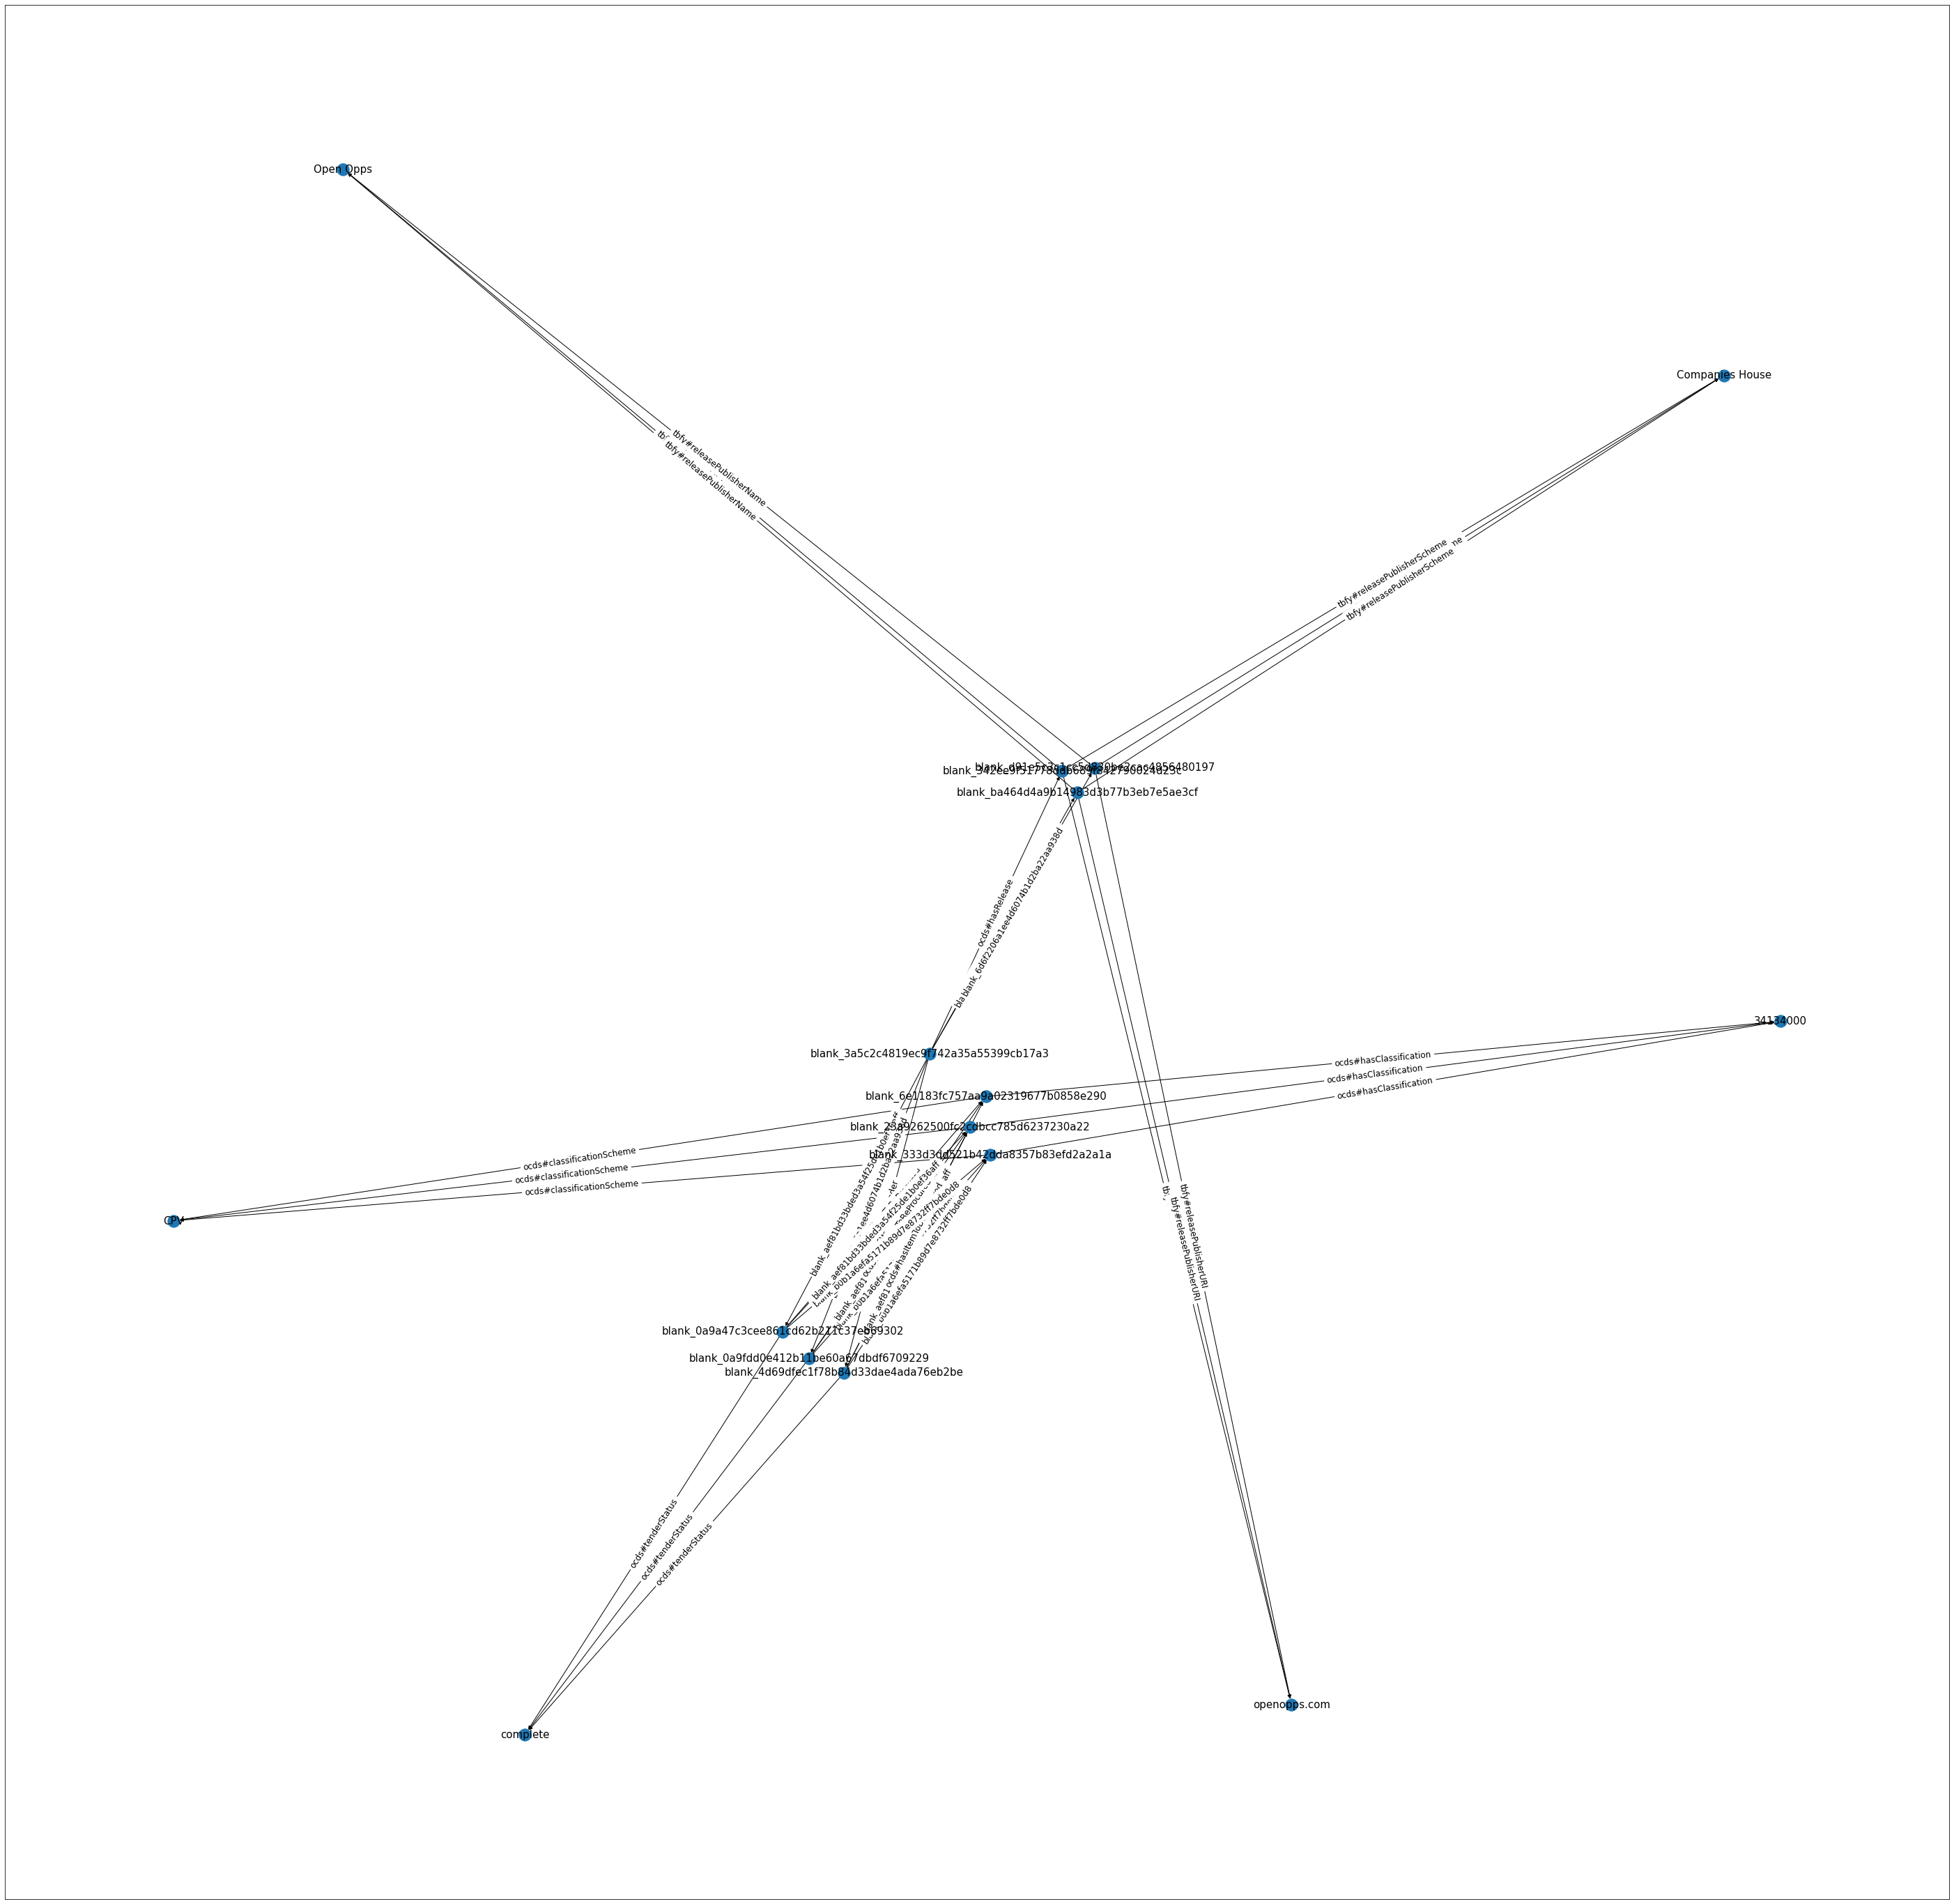

In [10]:
rdf_to_plot(graph_1, directory)
print("LCS finale tra le risorse: " + str(explored_resoures))

In [11]:
# SALVATAGGIO DEL GRAFO

rdf_to_text(graph_1, directory, 'turtle', 'final_LCS')
rdf_to_text(graph_1, directory, 'nt', 'final_LCS')
file =  open(directory + "/final_LCS_resources.log", "a")
file.write(str(explored_resoures))
file.close()